# Use Case : Monte Carlo valuation of (European call) options (BSM Setup)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def bsm_mcs_valuation(strike):
    #only strike allowed to vary
    import numpy as np
    S0 = 100.; T = 1.0; r = 0.05; vola = 0.2
    M = 50; I = 20000
    dt = T / M
    rand = np.random.standard_normal((M + 1, I))
    S = np.zeros((M + 1, I)); S[0] = S0
    for t in range(1, M + 1):
        S[t] = S[t-1] * np.exp((r - 0.5 * vola ** 2) * dt
                               + vola * np.sqrt(dt) * rand[t])
    
    value = (np.exp(-r * T)
    * np.sum(np.maximum(S[-1] - strike, 0)) / I)
    return value

# Sequential Calculation

In [5]:
#valuation of 100 options with different strike prices
#below function calculates MC estimators and return list objects containing strikes and valuations

def seq_value(n):
    
    strikes = np.linspace(80,120,n)
    option_values = []
    for strike in strikes :
        option_values.append(bsm_mcs_valuation(strike))
    return strikes , option_values

In [6]:
n = 100 #number of options to be valued

In [7]:
%time strikes, option_values_seq = seq_value(n)

CPU times: user 6.03 s, sys: 568 ms, total: 6.6 s
Wall time: 6.6 s


Text(0,0.5,'European call option values')

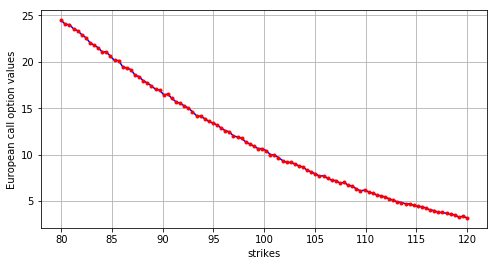

In [8]:
%matplotlib inline
plt.figure(figsize=(8,4))
plt.plot(strikes, option_values_seq,'b')
plt.plot(strikes, option_values_seq,'r.')
plt.grid(True)
plt.xlabel('strikes')
plt.ylabel('European call option values')

# Parallel Calculation

In [9]:
from ipyparallel import Client

In [10]:
c = Client(profile="default")
view = c.load_balanced_view()

In [11]:
def par_value(n):
    strikes = np.linspace(80, 120, n)
    option_values = []
    for strike in strikes:
        value = view.apply_async(bsm_mcs_valuation, strike)
        option_values.append(value)
    c.wait(option_values)
    return strikes, option_values

In [12]:
%time strikes, option_values_obj = par_value(n)

CPU times: user 689 ms, sys: 69.3 ms, total: 758 ms
Wall time: 3.17 s


In [30]:
option_values_par = []
for res in option_values_obj:
    option_values_par.append(res.get())

Text(0,0.5,'European call option values')

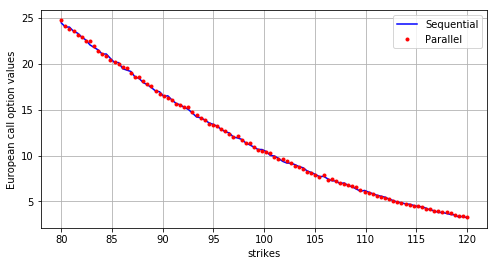

In [32]:
plt.figure(figsize=(8, 4))
plt.plot(strikes, option_values_seq, 'b', label='Sequential')
plt.plot(strikes, option_values_par, 'r.', label='Parallel')
plt.grid(True); plt.legend(loc=0)
plt.xlabel('strikes')
plt.ylabel('European call option values')

In [33]:
#Performance Comparison

In [34]:
def perf_comp_data(func_list,data_list,rep=3,number=1):
    ''' Function to compare the performance of different functions.
        Parameters
        ==========
        func_list : list
        list with function names as strings
        data_list : list
        list with data set names as strings
        rep : int
        number of repetitions of the whole comparison
        number : int
        number of executions for every function
    '''
    from timeit import repeat
    res_list = {}
    for name in enumerate(func_list):
        stmt = name[1] + '(' + data_list[name[0]] + ')'
        setup = "from __main__ import " + name[1] + ', ' \
        + data_list[name[0]]
        results = repeat(stmt=stmt, setup=setup,
        repeat=rep, number=number)
        res_list[name[1]] = sum(results) / rep
        res_sort = sorted(res_list.iteritems(),
        key=lambda (k, v): (v, k))
    for item in res_sort:
        rel = item[1] / res_sort[0][1]
        print 'function: ' + item[0] + \
        ', av. time sec: %9.5f, ' % item[1] \
        + 'relative: %6.1f' % rel

In [35]:
n = 50
func_list = ['seq_value', 'par_value']
data_list = 2 * ['n']

In [36]:
perf_comp_data(func_list, data_list)

function: par_value, av. time sec:   1.91111, relative:    1.0
function: seq_value, av. time sec:   3.41817, relative:    1.8
